# Notebook for analysis of all models

In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from util_funcs import load_split_data, sentence_embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score

from keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU, LayerNormalization, Bidirectional
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [2]:
# setup PyTorch backend
import os
os.environ['KERAS_BACKEND'] = 'torch'
import torch
print("Using PyTorch backend")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using PyTorch backend
Using device: cuda


In [3]:
# generate data splits
X_train, X_val, X_test, y_train, y_val, y_test = load_split_data("Sentiment_Analysis.csv")

## Embeddings

In [4]:
# embedding model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
# generate sentence embeddings
X_train_emb, X_val_emb, X_test_emb = sentence_embeddings((X_train, X_val, X_test), emb_model)

Batches:   0%|          | 0/750 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Training embeddings shape: (24000, 384)
Validation embeddings shape: (8000, 384)
Test embeddings shape: (8000, 384)


In [6]:
# pad sequences
import nltk
nltk.download("punkt_tab")
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences

def process_text_sequences(max_length=40, padding='post', truncating='post'):
    """
    Convert texts to padded sequences of tokens.

    Args:
        max_length: Maximum sequence length (default: 40)
        padding: 'pre' or 'post' padding (default: 'post')
        truncating: 'pre' or 'post' truncation (default: 'post')

    Returns:
        X_train_padded: Padded training sequences
        X_val_padded: Padded validation sequences
        X_test_padded: Padded test sequences
    """
    data = [X_train, X_val, X_test]
    padded_sequences = []

    for texts in data:
        # Tokenize all texts
        sequences = [word_tokenize(text) for text in texts]

        # Convert tokens to numpy arrays with padding
        padded_sequences.append(pad_sequences(
            sequences=[s[:max_length] for s in sequences],  # Truncate if needed
            maxlen=max_length,
            padding=padding,
            truncating=truncating,
            dtype=object,  # Use object dtype for string tokens
            value=''  # Use empty string as padding token
        ))

    return tuple(padded_sequences)

X_train_padded, X_val_padded, X_test_padded = process_text_sequences()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [7]:
from functools import cache
@cache
def encode_words(model, text):
    return model.encode(text)

In [8]:
# convert padded sequences to embeddings
def create_embedding_sequences(model, max_length=40):
    """
    Convert sequences of words to sequences of embeddings using cached word vectors.
    Ensures all sequences have the same length through padding.

    Args:
        model: SentenceTransformer model
        max_length: Maximum sequence length (default: 40)
    Returns:
        X_train_embedded: Training embeddings
        X_val_embedded: Validation embeddings
        X_test_embedded: Test embeddings
    """
    data = [X_train_padded, X_val_padded, X_test_padded]
    embeddings = []
    embedding_dim = model.get_sentence_embedding_dimension()

    for sequences in data:
        n_sequences = len(sequences)

        # Initialize the output array with zeros
        embedded_seqs = np.zeros((n_sequences, max_length, embedding_dim))

        for i, seq in enumerate(sequences):
            # Get embeddings for non-empty tokens
            valid_tokens = [word for word in seq if word != '']
            # Truncate if necessary
            valid_tokens = valid_tokens[:max_length]
            # Create embeddings for valid tokens
            seq_embeddings = [encode_words(model, word) for word in valid_tokens]

            # Add embeddings to the output array with padding
            for j, embedding in enumerate(seq_embeddings):
                if j < max_length:
                    embedded_seqs[i, j] = embedding
        embeddings.append(embedded_seqs)
        print(f"Shape: {embedded_seqs.shape}")

    return tuple(embeddings)

In [9]:
%%time
# generate sequence embeddings
X_train_embedded, X_val_embedded, X_test_embedded = create_embedding_sequences(emb_model)

Shape: (24000, 40, 384)
Shape: (8000, 40, 384)
Shape: (8000, 40, 384)
CPU times: user 5min 24s, sys: 1.29 s, total: 5min 26s
Wall time: 5min 26s


## MLP

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [11]:
# mlp
mlp_model = Sequential([
    Dense(16, activation='relu', input_shape=(384,)),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()
mlp_history = mlp_model.fit(X_train_emb, y_train, validation_data=(X_val_emb, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         6,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,925 (27.05 KB)

 Trainable params: 6,925 (27.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2414 - loss: 2.2178 - val_accuracy: 0.3289 - val_loss: 1.9225
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3445 - loss: 1.9072 - val_accuracy: 0.3495 - val_loss: 1.8816
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3586 - loss: 1.8649 - val_accuracy: 0.3545 - val_loss: 1.8637
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3716 - loss: 1.8447 - val_accuracy: 0.3554 - val_loss: 1.8624
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3679 - loss: 1.8365 - val_accuracy: 0.3571 - val_loss: 1.8597
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3813 - loss: 1.8221 - val_accuracy: 0.3599 - val_loss: 1.8536
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3733 - loss: 1.8164 - val_accuracy: 0.3604 - val_loss: 1.8555
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3852 - loss: 1.7947 - val_accuracy: 0.

In [12]:
# evaluate on test set
mlp_loss, mlp_acc = mlp_model.evaluate(X_test_emb, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3591 - loss: 1.8464


## XGBoost

In [13]:
# xgboost
xgb_model = xgb.XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, early_stopping_rounds=5)
xgb_model.fit(X_train_emb, y_train, eval_set=[(X_val_emb, y_val)], verbose=10)
xgb_history = xgb_model.evals_result()

[0]	validation_0-mlogloss:2.44595
[10]	validation_0-mlogloss:2.15179
[20]	validation_0-mlogloss:2.03691
[30]	validation_0-mlogloss:1.97927
[40]	validation_0-mlogloss:1.94719
[50]	validation_0-mlogloss:1.92891
[60]	validation_0-mlogloss:1.91653
[70]	validation_0-mlogloss:1.90784
[80]	validation_0-mlogloss:1.90311
[90]	validation_0-mlogloss:1.89897
[100]	validation_0-mlogloss:1.89724
[110]	validation_0-mlogloss:1.89595
[120]	validation_0-mlogloss:1.89588
[126]	validation_0-mlogloss:1.89664


In [14]:
# evaluate on test set
xgb_preds = xgb_model.predict(X_test_emb)
xgb_acc = accuracy_score(y_test, xgb_preds)

## Vanilla RNN

In [15]:
# vanilla rnn
rnn_model = Sequential([
    SimpleRNN(32, input_shape=(40, 384), return_sequences=True),
    SimpleRNN(16),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()
rnn_history = rnn_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40, 32)         │        13,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,621 (57.11 KB)

 Trainable params: 14,621 (57.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.1943 - loss: 2.2540 - val_accuracy: 0.2160 - val_loss: 2.1468
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2134 - loss: 2.1526 - val_accuracy: 0.2160 - val_loss: 2.1462
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2100 - loss: 2.1518 - val_accuracy: 0.2116 - val_loss: 2.1467
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2126 - loss: 2.1436 - val_accuracy: 0.2160 - val_loss: 2.1466
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2104 - loss: 2.1502 - val_accuracy: 0.2160 - val_loss: 2.1472
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2137 - loss: 2.1483 - val_accuracy: 0.2249 - val_loss: 2.1464
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2123 - loss: 2.1402 - val_accuracy: 0.2115 - val_loss: 2.1461
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2200 - loss: 2.1402 - val_accuracy: 

In [16]:
# evaluate on test set
rnn_loss, rnn_acc = rnn_model.evaluate(X_test_embedded, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2218 - loss: 2.1331


## Gated RNN

In [17]:
# lstm
lstm_model = Sequential([
    LSTM(32, input_shape=(40, 384), return_sequences=True),
    LSTM(16, dropout=0.2, return_sequences=True),
    LSTM(16, dropout=0.2),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()
lstm_history = lstm_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 40, 32)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 40, 16)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,149 (231.05 KB)

 Trainable params: 59,149 (231.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.2307 - loss: 2.1908 - val_accuracy: 0.2770 - val_loss: 2.0627
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2742 - loss: 2.0450 - val_accuracy: 0.3072 - val_loss: 1.9804
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3241 - loss: 1.9655 - val_accuracy: 0.3410 - val_loss: 1.9205
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3369 - loss: 1.9205 - val_accuracy: 0.3524 - val_loss: 1.8976
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3474 - loss: 1.8965 - val_accuracy: 0.3570 - val_loss: 1.8961
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3521 - loss: 1.8942 - val_accuracy: 0.3584 - val_loss: 1.8875
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3634 - loss: 1.8801 - val_accuracy: 0.3537 - val_loss: 1.8984
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3633 - loss: 1.8656 - val_acc

In [18]:
# evaulate on test set
lstm_loss, lstm_acc = lstm_model.evaluate(X_test_embedded, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3616 - loss: 1.8541


In [19]:
# gru
gru_model = Sequential([
    GRU(16, input_shape=(40, 384), return_sequences=True),
    GRU(16, dropout=0.3),
    LayerNormalization(),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()
gru_history = gru_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 40, 16)         │        19,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         1,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 16)             │            32 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,453 (83.80 KB)

 Trainable params: 21,453 (83.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.1949 - loss: 2.2540 - val_accuracy: 0.2216 - val_loss: 2.1452
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2228 - loss: 2.1488 - val_accuracy: 0.2541 - val_loss: 2.1317
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.2562 - loss: 2.1248 - val_accuracy: 0.2777 - val_loss: 2.0871
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2759 - loss: 2.0742 - val_accuracy: 0.3147 - val_loss: 2.0166
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3166 - loss: 1.9964 - val_accuracy: 0.3543 - val_loss: 1.9221
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3442 - loss: 1.9137 - val_accuracy: 0.3599 - val_loss: 1.9004
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3494 - loss: 1.8983 - val_accuracy: 0.3570 - val_loss: 1.8933
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.3652 - loss: 1.8731 - val_accuracy: 

In [20]:
# evaulate on test set
gru_loss, gru_acc = gru_model.evaluate(X_test_embedded, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3594 - loss: 1.8524


## Bidirectional RNN

In [21]:
# bidirectional gru
bidir_model = Sequential([
    Bidirectional(GRU(32, return_sequences=True), input_shape=(40, 384)),
    LayerNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(16)),
    LayerNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(13, activation='softmax')
])

bidir_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bidir_model.summary()
bidir_history = bidir_model.fit(X_train_embedded, y_train, validation_data=(X_val_embedded, y_val), epochs=30, callbacks=[early_stop])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 40, 64)         │        80,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 40, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 13)             │           221 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,069 (347.93 KB)

 Trainable params: 89,069 (347.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.2104 - loss: 2.2545 - val_accuracy: 0.3151 - val_loss: 1.9988
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3084 - loss: 1.9913 - val_accuracy: 0.3471 - val_loss: 1.9182
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3325 - loss: 1.9313 - val_accuracy: 0.3550 - val_loss: 1.8822
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3503 - loss: 1.8918 - val_accuracy: 0.3636 - val_loss: 1.8669
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3532 - loss: 1.8777 - val_accuracy: 0.3735 - val_loss: 1.8562
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3647 - loss: 1.8567 - val_accuracy: 0.3745 - val_loss: 1.8457
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3711 - loss: 1.8320 - val_accuracy: 0.3711 - val_loss: 1.8405
Epoch 8/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3763 - loss: 1.8227 - 

In [22]:
# evaulate on test set
bidir_loss, bidir_acc = bidir_model.evaluate(X_test_embedded, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3672 - loss: 1.8133


## Transformer

In [23]:
# Import required layers for transformer
from keras.layers import MultiHeadAttention, Input, GlobalAveragePooling1D, Add
from keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self attention with residual connection
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=head_size,
        dropout=dropout
    )(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])  # Residual connection
    x1 = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed-forward network with residual connection
    ffn_output = Dense(ff_dim, activation="relu")(x1)
    ffn_output = Dense(inputs.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    x2 = Add()([x1, ffn_output])  # Residual connection
    return LayerNormalization(epsilon=1e-6)(x2)

# Build the transformer model
def build_transformer_model(
    max_seq_length=40,
    embed_dim=384,
    num_heads=4,  # Reduced from 8 to better match embedding dimension
    ff_dim=512,   # Increased feed-forward dimension
    num_transformer_blocks=2,
    mlp_units=[256, 128],  # Increased MLP units
    dropout=0.1,
    mlp_dropout=0.1,
):
    inputs = Input(shape=(max_seq_length, embed_dim))
    x = inputs

    # Add positional encoding if needed (not required if using pre-trained embeddings)
    # x = positional_encoding(x)

    # Transformer blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, embed_dim // num_heads, num_heads, ff_dim, dropout)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # MLP layers with residual connections
    for dim in mlp_units:
        x_residual = x
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
        if x_residual.shape[-1] == dim:  # Only add if dimensions match
            x = Add()([x, x_residual])
        x = LayerNormalization(epsilon=1e-6)(x)

    # Classification layer
    outputs = Dense(13, activation="softmax")(x)

    return Model(inputs, outputs)

# Create and compile the model
print("Building transformer model...")
transformer_model = build_transformer_model(
    max_seq_length=40,
    embed_dim=384,
    num_heads=4,      # Adjusted to work better with embedding dimension
    ff_dim=512,       # Increased feed-forward dimension
    num_transformer_blocks=2,
    mlp_units=[256, 128],  # Increased MLP units
    dropout=0.1,
    mlp_dropout=0.1,
)

Building transformer model...


In [24]:
from keras.optimizers import Adam

# Compile the model
transformer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Model summary
transformer_model.summary()

# Add early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train the model with early stopping
print("\nTraining Transformer model...")
transformer_history = transformer_model.fit(
    X_train_embedded,  # Use embedded sequences
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_embedded, y_val),  # Use embedded validation sequences
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 40, 384)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 384)   │    591,360 │ input_layer_5[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 40, 384)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 384)   │          0 │ input_layer_5[0]… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 40, 512)   │    197,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 40, 384)   │    196,992 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 40, 384)   │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 40, 384)   │    591,360 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 40, 384)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 40, 512)   │    197,120 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 40, 384)   │    196,992 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 40, 384)   │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 40, 384)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 40, 384)   │        768 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,107,917 (8.04 MB)

 Trainable params: 2,107,917 (8.04 MB)

 Non-trainable params: 0 (0.00 B)


Training Transformer model...
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.2160 - loss: 2.2239 - val_accuracy: 0.2848 - val_loss: 2.0444
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2970 - loss: 2.0239 - val_accuracy: 0.3438 - val_loss: 1.9678
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3291 - loss: 1.9882 - val_accuracy: 0.3095 - val_loss: 1.9944
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3222 - loss: 1.9780 - val_accuracy: 0.3391 - val_loss: 1.9619
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3353 - loss: 1.9498 - val_accuracy: 0.2640 - val_loss: 2.0591
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.2899 - loss: 2.0268 - val_accuracy: 0.3219 - val_loss: 1.9562
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.3165 - loss: 1.9472 - val_accuracy: 0.3359 - val_loss: 1.9170
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 

In [25]:
# evaluate on test set
transformer_loss, transformer_acc = transformer_model.evaluate(X_test_embedded, y_test)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3601 - loss: 1.8714


## Plots/tables

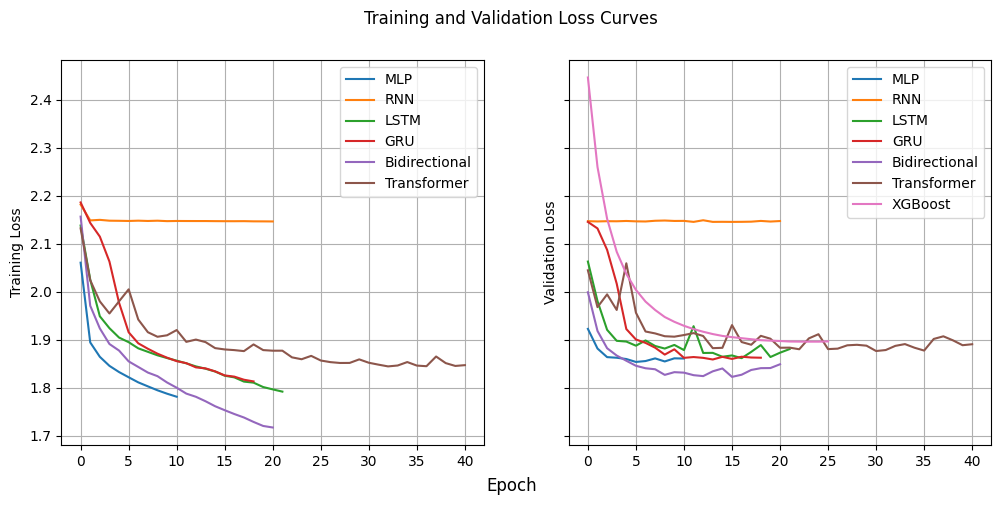

In [30]:
# training/validation loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

ax1.plot(mlp_history.history['loss'], label='MLP')
ax1.plot(rnn_history.history['loss'], label='RNN')
ax1.plot(lstm_history.history['loss'], label='LSTM')
ax1.plot(gru_history.history['loss'], label='GRU')
ax1.plot(bidir_history.history['loss'], label='Bidirectional')
ax1.plot(transformer_history.history['loss'], label='Transformer')
ax1.legend()
ax1.set_ylabel('Training Loss')
ax1.grid()

ax2.plot(mlp_history.history['val_loss'], label='MLP')
ax2.plot(rnn_history.history['val_loss'], label='RNN')
ax2.plot(lstm_history.history['val_loss'], label='LSTM')
ax2.plot(gru_history.history['val_loss'], label='GRU')
ax2.plot(bidir_history.history['val_loss'], label='Bidirectional')
ax2.plot(transformer_history.history['val_loss'], label='Transformer')
ax2.plot(xgb_history['validation_0']['mlogloss'][::5], label='XGBoost')
ax2.legend()
ax2.set_ylabel('Validation Loss')
ax2.grid()

fig.suptitle('Training and Validation Loss Curves')
fig.supxlabel('Epoch')
plt.show()

In [27]:
# metrics table
test_metrics = pd.DataFrame({
    'Model': ['MLP', 'RNN', 'LSTM', 'GRU', 'Bidirectional', 'Transformer', 'XGBoost'],
    'Test Accuracy': [mlp_acc, rnn_acc, lstm_acc, gru_acc, bidir_acc, transformer_acc, xgb_acc],
    'Test Loss': [mlp_loss, rnn_loss, lstm_loss, gru_loss, bidir_loss, transformer_loss, np.nan]
}).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

test_metrics.round(3).replace(np.nan, "N/A")

,Model,Test Accuracy,Test Loss
0,Bidirectional,0.368,1.824
1,LSTM,0.364,1.865
2,MLP,0.361,1.858
3,GRU,0.359,1.863
4,Transformer,0.359,1.885
5,XGBoost,0.348,N/A
6,RNN,0.216,2.145


250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


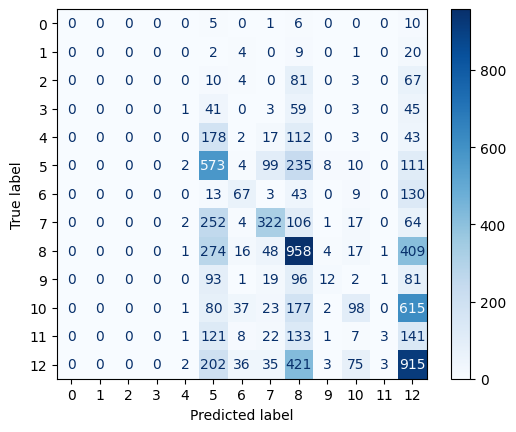

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# confusion matrix for bidirectional
bidir_preds = bidir_model.predict(X_test_embedded)
conf_mat = confusion_matrix(y_test, np.argmax(bidir_preds, axis=1))
ConfusionMatrixDisplay(conf_mat).plot(cmap="Blues")
plt.show()

## Takeaways

- The bidirectional RNN is the best performing model overall during the training/validation phase as well as when assessing on a new testing set
- The more complex Transformer model actually performs poorly compared to simpler model architectures despite training for longer epochs
- The somewhat poor overall performance reflects the difficulty of this multiclass classification problem, and the confusion matrix indicates that the predictions are hihgly concentrated in a few prominent classes